# Solving the Van der Pol oscillator with the DeepXDE Framework
Raihaan Usman, UROP Student

DeepXDE is a data-driven framework developed by researchers at Brown University.

In [111]:
# surpress warnings from imports
import warnings
# warnings.filterwarnings("ignore")

import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# import wandb

# wandb.init(project="PINNs", entity="raihaan123")

# sweep_config = {
#     'method': 'random'
#     }

### Van der Pol Solver

Compiling model...
Building feed-forward neural network...
'build' took 0.104106 s

'compile' took 7.073437 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.29e-02, 6.88e-01, 6.56e-02]    [2.21e-02, 6.88e-01, 6.56e-02]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000004
  Number of iterations: 693
  Number of functions evaluations: 848
848       [4.18e-06, 2.22e-10, 1.44e-10]    [3.89e-06, 2.22e-10, 1.44e-10]    []  

Best model at step 848:
  train loss: 4.18e-06
  test loss: 3.89e-06
  test metric: []

'train' took 84.076481 s

Saving loss history to /workspaces/UROP-Notes/src/loss.dat ...
Saving training data to /workspaces/UROP-Notes/src/train.dat ...
Saving test data to /workspaces/UROP-Notes/src/test.dat ...


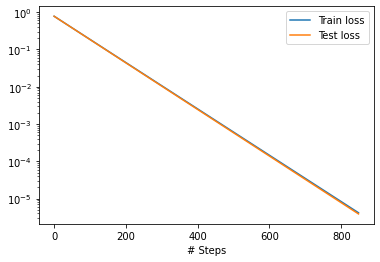

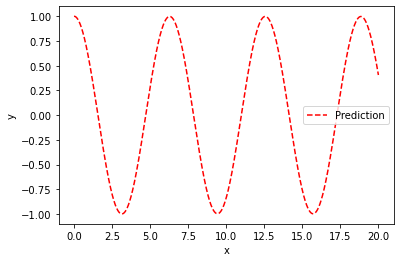

In [112]:
# PDE parameters
mu = 0
X0 = [1, 0]
t_f = 20

# Hyperparameters
alpha           = 0.005
loss_weights    = [3, 0.1, 0.1]    # [X, x1(0), x2(0)] errors

# VdP oscillator
ODE         = lambda X, t:  np.array([X[1], mu*(1-X[0]**2)*X[1]-X[0]])
true_sol    = lambda t:     odeint(ODE, X0, t)

# The PDE problem
def VdP(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return  d2y_dt2 - mu * (1 - y ** 2) * dy_dt + y

# Time domain definition
geom = dde.geometry.TimeDomain(0, t_f)

# Boundary domain function - for time domain
def boundary_l(t, on_initial):
    return on_initial and np.isclose(t[0], 0)

# x1(0) = 0.5
bc_func1 = lambda inputs, outputs, X: outputs - X0[0]

# x2(0) = 0
bc_func2 = lambda inputs, outputs, X: dde.grad.jacobian(outputs, inputs, i=0, j=None) - X0[1]

# Defining as ICs
ic1 = dde.icbc.OperatorBC(geom, bc_func1, boundary_l)
ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)

# Define the PDE problem
data = dde.data.TimePDE(geom, VdP, [ic1, ic2], 300, 2, num_test=50000)

# Solver architecture
# layer_size = [1] + [5] * 3 + [1]
layer_size = [1] + [10]*2 + [2]*2 + [10]*2 + [1]          # Fun experiment! Does there exist a linear coordinate frame for the ODE?
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)


def input_transform(t):
    return tf.concat(
        (
            t,
            # t%1,
            # tf.log_sigmoid(t),
            tf.cos(t),
            tf.sin(t)
            # tf.sin(2 * t),
            # tf.sin(3 * t),
            # tf.sin(4 * t)
        ),
        axis=1,
    )

net.apply_feature_transform(input_transform)


# Create a Model using the PDE and neural network definitions
model = dde.Model(data, net)

# Compile the model!


# Recompile with new optimizer L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# model.compile(
#     "adam", lr=alpha, loss_weights=loss_weights     # Removed metrics=["l2 relative error"]
# )

# losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

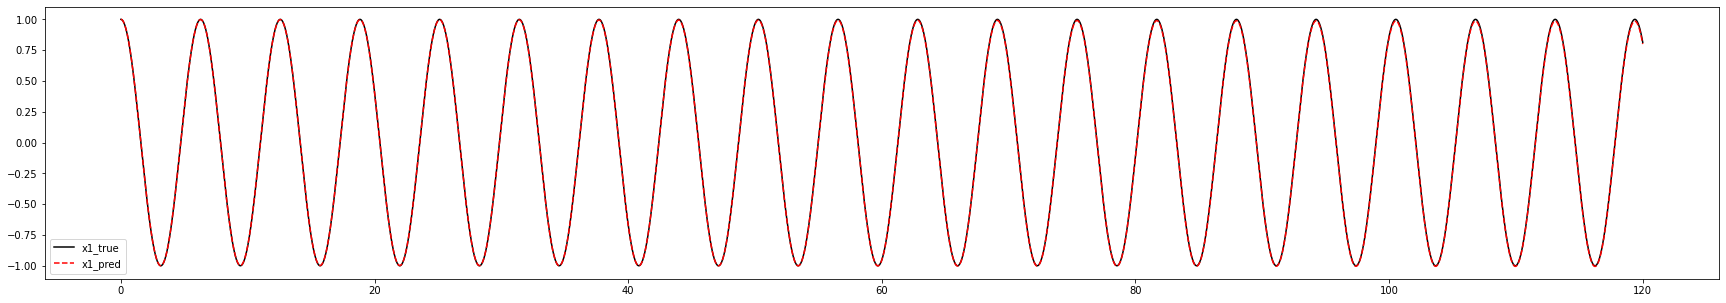

In [113]:
t = np.linspace(0, t_f+100, 5000)
sol = true_sol(t)
x1, x2 = np.hsplit(true_sol(t), 2)

# Plot the solution
plt.figure(figsize=(30, 5))
plt.plot(t, x1, color="black", label="x1_true")

t = t.reshape(5000, 1)
x1_pred = model.predict(t)

plt.plot(t, x1_pred, color="red", linestyle="dashed", label="x1_pred")
plt.legend()
plt.show()